## <span style="color:blue;">STEP 1: DATA VISUALIZATION</span>

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

X = np.load('X.npy')
y = np.load('y.npy')  

print("X_features shape:", X.shape)
print("y shape:", y.shape)

X_features shape: (800, 1000, 501)
y shape: (800,)


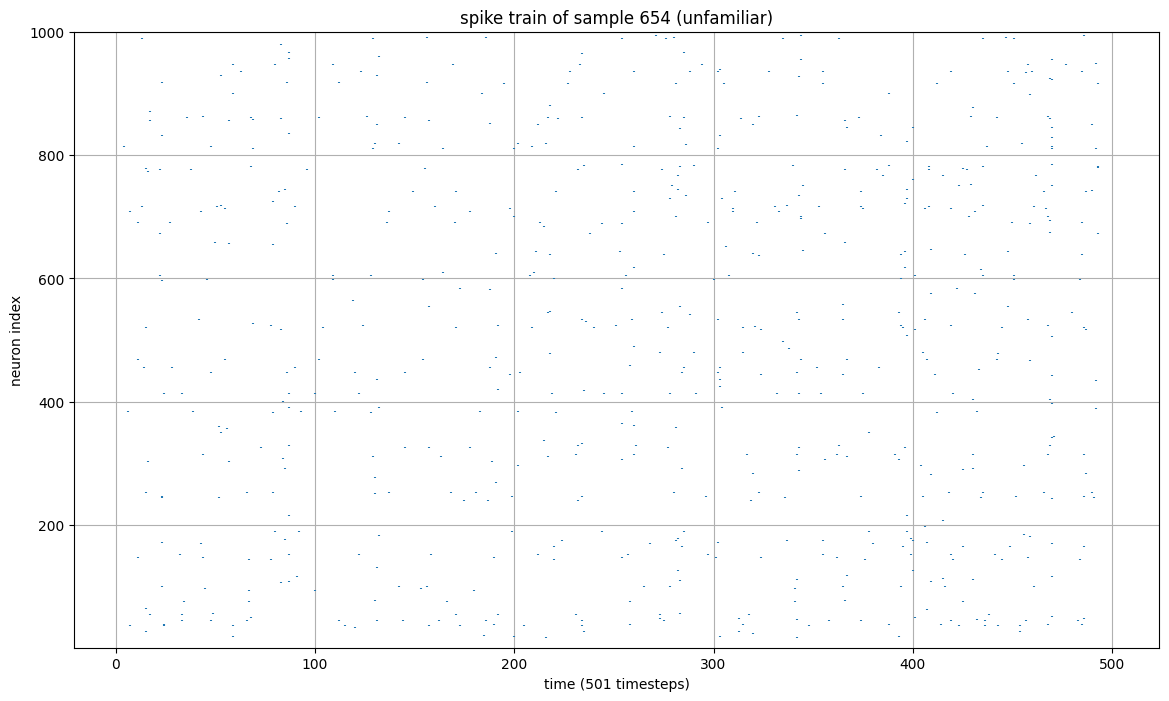

In [242]:
########################### look at one idividual sample #########################

sample_nr=654
sample = X[sample_nr] 
label = y[sample_nr]


plt.figure(figsize=(14, 8))

for neuron_idx in range(1000):
    spike_times = np.where(sample[neuron_idx] > 0)[0]
    plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5)

plt.title(f"spike train of sample {sample_nr} {'(familiar)' if label == 1 else '(unfamiliar)'}")
plt.xlabel("time (501 timesteps)")
plt.ylabel("neuron index")
plt.ylim(0.5, 1000.5)
plt.grid(True)
#plt.tight_layout()
plt.show()


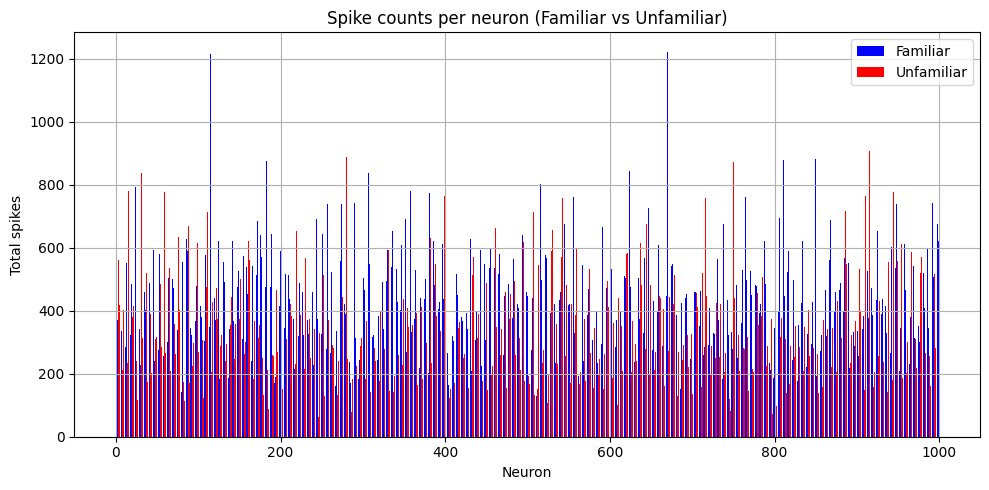

Neuron	Familiar	Unfamiliar	Diff (Unf - Fam)	% Diff (abs)
--------------------------------------------------------------------------------
83	391		113		-278			55.16
797	212		72		-140			49.30
917	482		174		-308			46.95
755	251		92		-159			46.36
451	390		148		-242			44.98


In [243]:
########################### IDENTIFY CRITICAL SINGLE NEURONS #########################

#familiar trials
X_fam = X[y == 1]
total_spikes_fam = np.sum(X_fam, axis=(0, 2))

#unfamiliar trials
X_unfam = X[y == 0]
total_spikes_unfam = np.sum(X_unfam, axis=(0, 2))

######################## Plot total spikes for familiar and unfamiliar trials #########################

n_neurons = X.shape[1]
x = np.arange(n_neurons)

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, total_spikes_fam, width=0.4, label="Familiar", color='blue')
plt.bar(x + 0.2, total_spikes_unfam, width=0.4, label="Unfamiliar", color='red')
plt.xlabel("Neuron")
plt.ylabel("Total spikes")
plt.title("Spike counts per neuron (Familiar vs Unfamiliar)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


########################### Print table of largest firing rate differences ###########


#percentage difference for each neuron
percent_diffs = []
for fam, unfam in zip(total_spikes_fam, total_spikes_unfam):
    diff = unfam - fam
    total = fam + unfam
    percent = (abs(diff) / total) * 100
    percent_diffs.append(percent)

#sort by descending percentage difference 
sorted_indices = np.argsort(percent_diffs)[::-1]

sorted_indices = sorted_indices[:5]  #keep only top 5

#table
print("Neuron\tFamiliar\tUnfamiliar\tDiff (Unf - Fam)\t% Diff (abs)")
print("-" * 80)
for i in sorted_indices:
    fam = total_spikes_fam[i]
    unfam = total_spikes_unfam[i]
    diff = unfam - fam
    total = fam + unfam
    ratio = (abs(diff) / total) * 100 if total != 0 else 0
    print(f"{i}\t{fam:.0f}\t\t{unfam:.0f}\t\t{diff:.0f}\t\t\t{ratio:.2f}")
    

#### Observations:

I attempted to identify single neurons that may play a critical role in distinguishing familiar from unfamiliar trials by comparing total spike counts across the two groups. The neurons with the largest relative differences in spike activity were ranked, with the top neuron showing only a 55% difference between conditions while also not firing that often in general. And most neurons show much smaller differences.
This suggests that no single neuron is highly discriminative on its own, and that meaningful separation of familiar and unfamiliar trials likely happens at the population level, through combined activity patterns rather than isolated units.
I could still try to only focus on the most important neurons if i wanted the most simple model I can find, but for now I will not pursue the idea any further.


## <span style="color:blue;">STEP 2: DATA TRANSFORMATION</span>
### Neural coding techniques I'd like to try:

#### Rate Coding:
    -Compute Mean Firing Rate (average spikes per neuron over time).
    -Compute Fano Factor (variability of spike counts over time).

#### Temporal Coding:
    -Fast Fourier Transform(FFT).
        -Power in low-frequency bands (0–40 Hz).
        -Peak frequencies (frequency with highest power).

#### Population Coding:
    Synchrony Variance (how much neurons fire together at each time point).

In [244]:
def compute_features(X):
    n_samples = X.shape[0]
    features = []

    #just for clarification:
    #shape[0] = number of samples
    #shape[1] = number of neurons
    #shape[2] = number of timesteps

    for i in range(n_samples):
        x = X[i]

        #total spikes
        total_spikes = np.sum(x)

        #mean firing rate
        firing_rate= np.sum(x,axis=1) /x.shape[1]
        mean_firing_rate = np.mean(firing_rate)

        #mean_firing_rate = total_spikes / (x.shape[0] * x.shape[1])

        # hier vielleicht noch firing rate pro timestep
        

        #synchrony variance
        total_spikes_per_time = np.sum(x, axis=0)
        synchrony_variance = np.var(total_spikes_per_time)

         # Fano Factor
        mean_spikes = np.mean(total_spikes_per_time)
        var_spikes = np.var(total_spikes_per_time)
        fano_factor = var_spikes / mean_spikes

        #fast forurier transormation------------------------------------------------------------------
        
        #apply fft
        fft = np.fft.fft(total_spikes_per_time)
        fft = fft[:len(fft)//2]#keep only positive frequencies

        #power--------------------------
        
        power = np.mean(np.abs(fft[:20]) ** 2)#only first 20 bins(40Hz)

        #peak frequency-----------------

        #i remove the mean from the total spikes because else shows peak frequencies at 0 (DC component)
        total_spikes_per_time = total_spikes_per_time - np.mean(total_spikes_per_time)

        #remove everything above 40Hz (20 bins)
        fft = np.fft.fft(total_spikes_per_time[:20])

        #remove 0 hz component (DC component)
        fft[0] = 0

        #redo fft
        #fft = np.fft.fft(total_spikes_per_time)
        fft = fft[:len(fft)//2]#keep only positive frequencies

        #find the bin with the highest power
        peak_idx = np.argmax(np.abs(fft))

        #i could do this fancier but i am not even quite sure if 1 timestep is really 1ms
        #i just want the scale to be more interpretable
        peak_frequency = peak_idx * 2 #so 2 Hz per bin

        #----------------------------------------------------------------------------------------------

        #collect features in dict
        sample_features = {
            'mean_firing_rate': mean_firing_rate,
            'synchrony_variance': synchrony_variance,
            'power': power,
            'peak_frequency': peak_frequency,
            'fano_factor': fano_factor
        }

        features.append(sample_features)

    #make a dataframe so i dont get cofused with axis anymore
    features_df = pd.DataFrame(features)

    return features_df

  
#just for testing purposes
#print(features.shape)
#print ("mfr:", features[:, 0])
#print ("sv:", features[:, 1])
#print ("power:", features[:, 2])



## <span style="color:blue;">STEP 3: EXPLORATORY ANALYSIS</span>

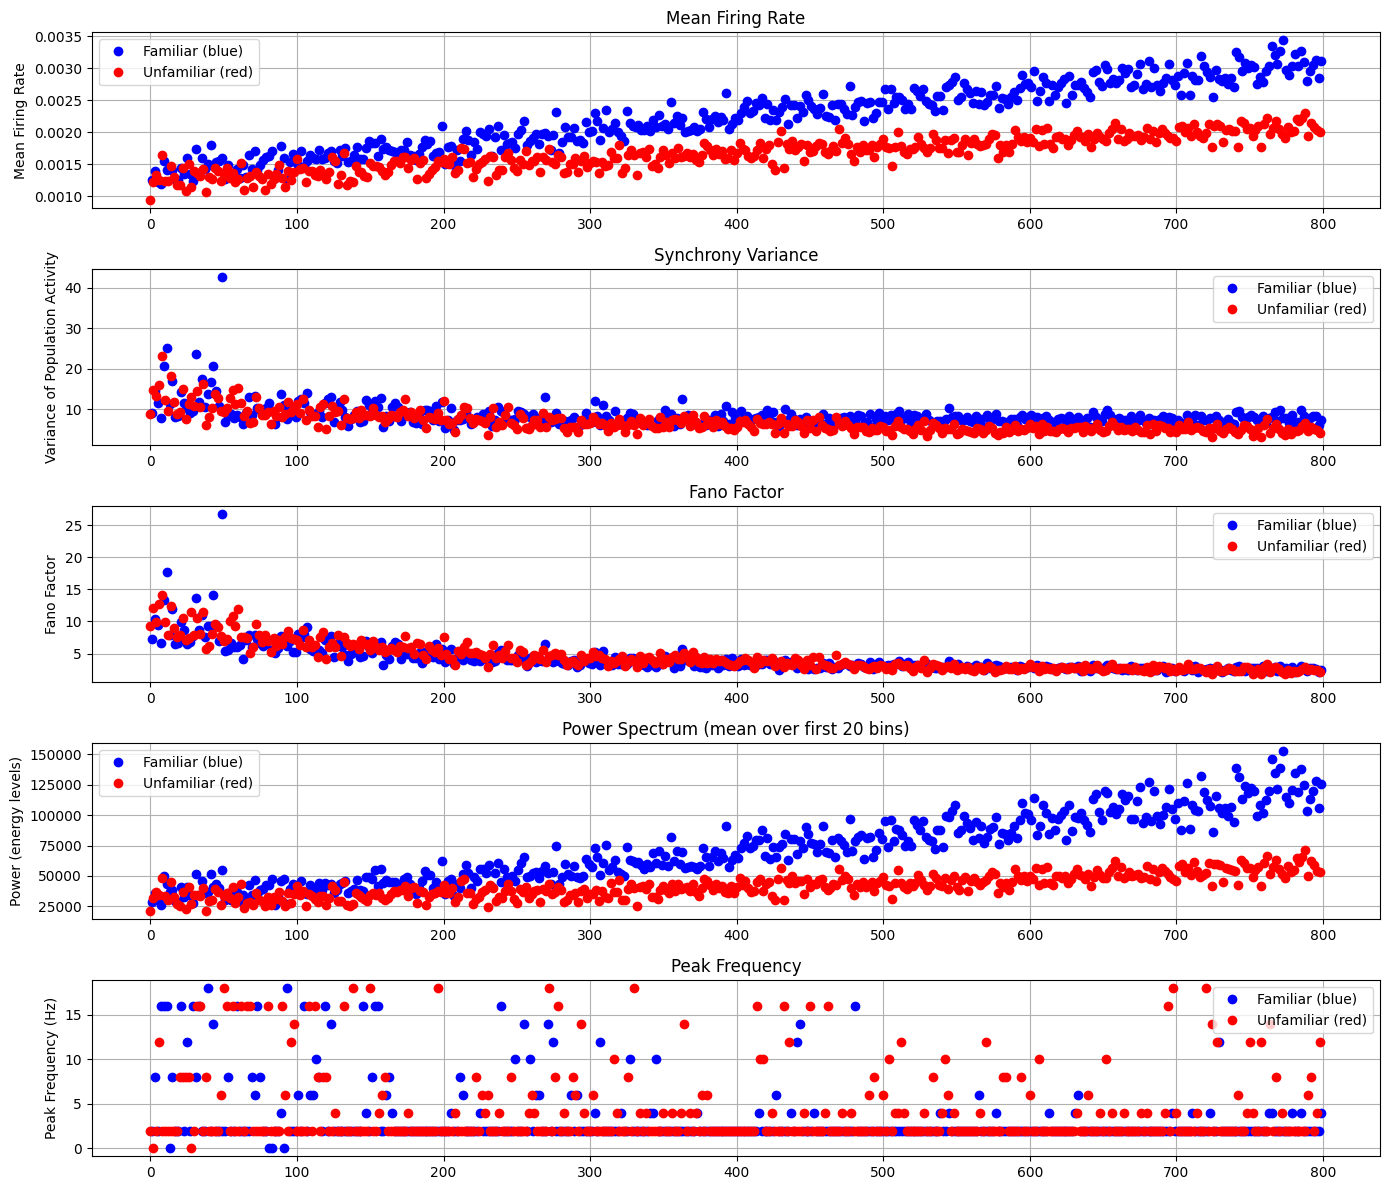

In [245]:
############### PLOT EVERYTHING ####################

features = compute_features(X)

nr_of_features=5

# print first 5 samples for quick check
#print(features.head())

plt.figure(figsize=(14, 12))

# 1. Mean Firing Rate
plt.subplot(nr_of_features, 1, 1)
plt.title("Mean Firing Rate")
plt.ylabel("Mean Firing Rate")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'mean_firing_rate'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'mean_firing_rate'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 2. Synchrony Variance
plt.subplot(nr_of_features, 1, 2)
plt.title("Synchrony Variance")
plt.ylabel("Variance of Population Activity")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'synchrony_variance'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'synchrony_variance'], 'ro', label='Unfamiliar (red)')
plt.legend()

#3. Fano Factor
plt.subplot(nr_of_features, 1, 3)
plt.title("Fano Factor")
plt.ylabel("Fano Factor")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'fano_factor'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'fano_factor'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 4. Power
plt.subplot(nr_of_features, 1, 4)
plt.title("Power Spectrum (mean over first 20 bins)")
plt.ylabel("Power (energy levels)")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'power'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'power'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 5. Peak Frequency
plt.subplot(nr_of_features, 1, 5)
plt.title("Peak Frequency")
plt.ylabel("Peak Frequency (Hz)")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'peak_frequency'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'peak_frequency'], 'ro', label='Unfamiliar (red)')
plt.legend()



plt.tight_layout()
plt.show()




### <span style="color:blue;">Observations</span>

- The earlier samples are providing overall less secure evidence for being familiar/not familiar than the later ones.(Maybe the neurons became more tuned to the stimuli over time.)

- The mean firing rate and the power of lower frequencies seem to provide strong distinctions between the two groups. Familiar examples show a higher firing rate than unfamiliar ones.

- Fano factor and peak frequencies can probably be ignored as it is unclear from the plots that the two groups differ. Maybe from from the variance of population activity I could extract some information, but it looks weak.

#### Further explaination of the methods used

- The mean firing rate was calculated by summing all spikes across neurons and dividing by the total number of neuron-time combinations (number of neurons × number of timepoints).

- Instead of printing the fft in its raw form, I used power (|fft signal|^2) and looked at the mean of the first 20 bins. This should give a detailed enough view of lower frequencies, while ignoring the high frequency noise. Frequency per bin=1/T. 1/0.5sec (assuming one time point is one millisecond) would make one bin be equivalent to (roughly) 2Hz. So 20 bins cover ca. 40Hz ​ 

- Peak frequency: After removing the mean from the spike signal, I applied FFT and then identified the frequency bin with the highest value. At first, the frequencies looked very random but after removing all peaks above 40Hz (and zero ones), i identified that there seems to be a prominent and consistent 2Hz Signal in all the samples. I can not distinguish the two groups for now, but maybe this will be interesting later?

- To capture how synchronized the population activity is, I summed spikes across neurons at each timepoint and calculated the variance over time. A higher variance suggests more synchronous bursts of activity, while lower variance indicates more random firing.

- For each trial I computed the mean and variance of the summed spike counts across time bins. The Fano factor is the variance divided by the mean. It measures how regular or irregular the firing is.



In [246]:
###################### Further Inspect Power Spectrum ####################

power= features['power'].values

peak_freqs = features['peak_frequency'].values

#divide into familiar and unfamiliar
peak_fam = peak_freqs[y == 1]
peak_unfam = peak_freqs[y == 0]

#calculating standard deviations
std_fam = np.sqrt(np.mean((peak_fam - np.mean(peak_fam)) ** 2))
std_unfam = np.sqrt(np.mean((peak_unfam - np.mean(peak_unfam)) ** 2))
std_peak = np.sqrt(np.mean((peak_freqs - np.mean(peak_freqs)) ** 2))


print(f"{'':<15}{'Mean(Hz)':>15}{'Std(Hz)':>15}")
print("_" * 50)
print(f"{'Familiar':<15}{np.mean(peak_fam):>15.2f}{std_fam:>15.2f}")
print(f"{'Unfamiliar':<15}{np.mean(peak_unfam):>15.2f}{std_unfam:>15.2f}")
print(f"{'Overall (Peak)':<15}{np.mean(peak_freqs):>15.2f}{std_peak:>15.2f}")

                      Mean(Hz)        Std(Hz)
__________________________________________________
Familiar                  3.37           3.51
Unfamiliar                4.16           4.18
Overall (Peak)            3.76           3.88


In [247]:
###################### Further Inspect Fano Factor ####################

fano = features['fano_factor'].values

#divide into familiar and unfamiliar
fano_fam = fano[y == 1]
fano_unfam = fano[y == 0]

#calculating standard deviations
std_fam = np.sqrt(np.mean((fano_fam - np.mean(fano_fam)) ** 2))
std_unfam = np.sqrt(np.mean((fano_unfam - np.mean(fano_unfam)) ** 2))
std_fano = np.sqrt(np.mean((fano - np.mean(fano)) ** 2))

# print table
print(f"{''}{'Mean':>25}{'Std':>15}")
print("_" * 45)
print(f"{'Familiar':<10}{np.mean(fano_fam):>15.2f}{std_fam:>15.2f}")
print(f"{'Unfamiliar':<10}{np.mean(fano_unfam):>15.2f}{std_unfam:>15.2f}")
print(f"{'Overall (Fano)':<10}{np.mean(fano):>11.2f}{std_fano:>15.2f}")


                     Mean            Std
_____________________________________________
Familiar             4.15           2.30
Unfamiliar           4.35           2.16
Overall (Fano)       4.25           2.23


### <span style="color:blue;">Observations</span>

The Fano factor analysis shows similar variability across both groups, with basically no differences in their means and standard deviations. This suggests that trial-to-trial variability in population spiking was generally stable and does not strongly distinguish between familiar and unfamiliar.

The power spectrum analysis shows that unfamiliar trials have a mean peak frequency of 4.16 Hz,familiar trials average 3.37 Hz. This suggests that unfamiliar stimuli tend to cause slightly faster oscillating neural activity, which may reflect increased attentional engagement or the processing of novel information.

I will now visualize the distributions of the extracted features using histograms. 




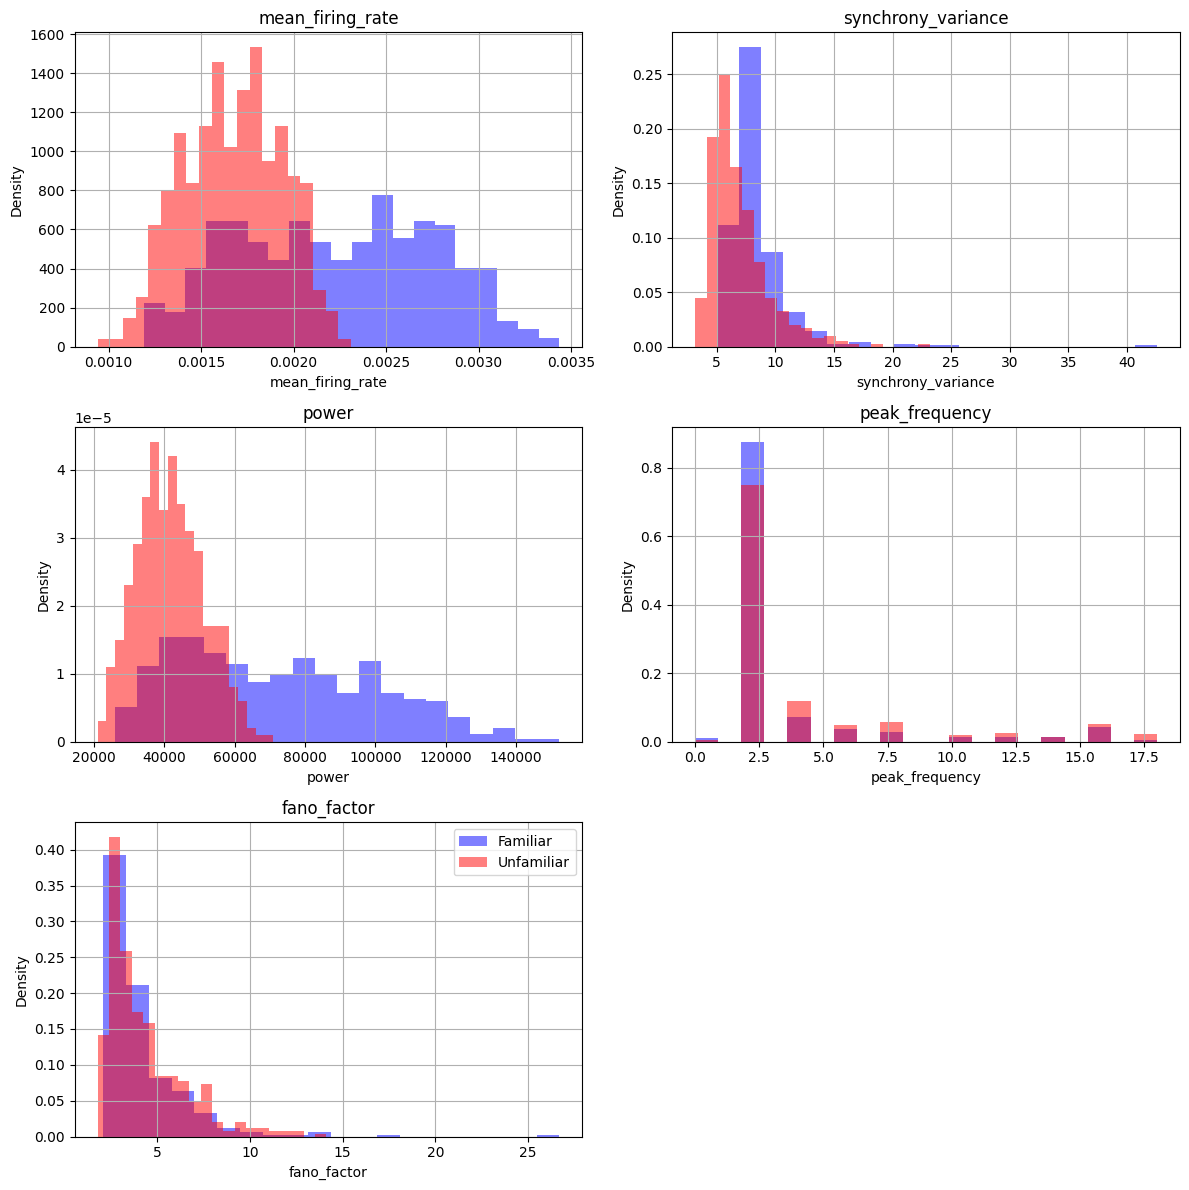

In [248]:
######################## Feature Distributions Histograms ######################## 

def plot_feature_distributions(features, y, feature_list):
    n_features = len(feature_list)
    n_cols = 2 #how many plots per row
    n_rows = (n_features + n_cols - 1) // n_cols #compute rows automatically B)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten() #flatten to make it easy to index

    for idx, feature_name in enumerate(feature_list):
        fam_values = features.loc[y == 1, feature_name].values
        unfam_values = features.loc[y == 0, feature_name].values

        ax = axes[idx]
        ax.hist(fam_values, bins=20, alpha=0.5, label='Familiar', color='blue', density=True)# density=True here the histogram gets normalized
        ax.hist(unfam_values, bins=20, alpha=0.5, label='Unfamiliar', color='red', density=True)
        ax.set_title(f"{feature_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel("Density")
        ax.grid(True)

    #hide empty subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.legend()
    plt.show()


feature_list = ['mean_firing_rate', 'synchrony_variance', 'power', 'peak_frequency', 'fano_factor']

plot_feature_distributions(features, y, feature_list)



I used overlaid histograms normalized to density.
Histograms are a more intuitive visualization of the full distribution of feature values.
The focus is on shape and spread, not total counts.

### <span style="color:blue;">Observations</span>

- There remains a great overlap between the groups, so perfect classification based on any single feature alone is impossible.

In [249]:
######################## Compute Cohen's d ########################

def cohen_d(x, y):
    #calculate cohen's d for two samples
    mean_x, mean_y = np.mean(x), np.mean(y)# calculate means
    var_x, var_y = np.var(x, ddof=1), np.var(y, ddof=1)# calculate variances
    pooled_std = np.sqrt((var_x + var_y) / 2)# pooled standard deviation
    d = (mean_x - mean_y) / pooled_std#
    return d

feature_list = ['mean_firing_rate', 'synchrony_variance', 'power', 'peak_frequency', 'fano_factor']

print(f"{'Feature':<25}{'Cohen´s d':>10}")
print("_" * 40)

#loop over all features 
for feature_name in feature_list:
    fam_values = features.loc[y == 1, feature_name].values
    unfam_values = features.loc[y == 0, feature_name].values

    d = cohen_d(fam_values, unfam_values)
    print(f"{feature_name:<25}{d:>10.2f}")

Feature                   Cohen´s d
________________________________________
mean_firing_rate               1.36
synchrony_variance             0.59
power                          1.46
peak_frequency                -0.20
fano_factor                   -0.09


Cohen’s d measures the difference between two group means divided by their pooled standard deviation.
I use it to quantify how different two groups are.
It gives a standardized, numerical measure of the separation between familiar and unfamiliar trials. High values mean the two groups are well separated.

In [250]:
def kl_divergence_numpy(p, q, bins=50):
    #histogram binning with density=True to normalize
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)

    #to avoid division by zero
    epsilon = 1e-10
    p_hist = p_hist + epsilon
    q_hist = q_hist + epsilon

    #normalize histograms
    p_hist /= np.sum(p_hist)
    q_hist /= np.sum(q_hist)

    # sum P(x) * log(P(x) /Q(x))
    kl = np.sum(p_hist * np.log(p_hist / q_hist))

    return kl

print(f"{'Feature':<25}{'KL Divergence':>15}")
print("_" * 45)
print(f"{'Mean Firing Rate':<25}{kl_divergence_numpy(features.loc[y == 1, 'mean_firing_rate'].values, features.loc[y == 0, 'mean_firing_rate'].values):>15.2f}")
print(f"{'Synchrony Variance':<25}{kl_divergence_numpy(features.loc[y == 1, 'synchrony_variance'].values, features.loc[y == 0, 'synchrony_variance'].values):>15.2f}")
print(f"{'Power':<25}{kl_divergence_numpy(features.loc[y == 1, 'power'].values, features.loc[y == 0, 'power'].values):>15.2f}")
print(f"{'Peak Frequency':<25}{kl_divergence_numpy(features.loc[y == 1, 'peak_frequency'].values, features.loc[y == 0, 'peak_frequency'].values):>15.2f}")
print(f"{'Fano Factor':<25}{kl_divergence_numpy(features.loc[y == 1, 'fano_factor'].values, features.loc[y == 0, 'fano_factor'].values):>15.2f}")



Feature                    KL Divergence
_____________________________________________
Mean Firing Rate                   13.66
Synchrony Variance                  0.52
Power                               5.30
Peak Frequency                      0.04
Fano Factor                         0.25


KL divergence tells you how different two distributions are by comparing their entire shape in contrast to just their means. Thats why the first and second place in difference switched.



### <span style="color:blue;">Observations</span>

- As expected, mean firing rate and low-frequency power show strong separation between familiar and unfamiliar trials. Synchrony variance shows moderate separation, peak frequency and fano factor little to none.

- Mean firing rate and power remain the two most promising measurements.

### <span style="color:blue;">Intermediate Conclusion</span>

I analyzed how much the neurons fire, how rhythmically they fire, and how much they fire together. I assessed which measurements are reliable. But now, they are still reliant on the sample-index-x-axis. Since a random new sample is unlikely to come with data about how far the experiment has progressed at the time of measurement, I should not include it in the classifier.

Now I can start to combine my best estimators in a model:

## <span style="color:blue;">STEP 4: MODEL TRAINING AND CLASSIFICATION</span>

I use **Logistic Regression** as the classification model.  
It is simple, fast, interpretable, and suitable for binary classification problems like this one.  
Since we have a small number of features and balanced classes, Logistic Regression is a reasonable first choice.

In [251]:
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import PolynomialFeatures

############################# Logistic Regression ###############################


selected_features = ['mean_firing_rate', 'power'] 
#selected_features = features.columns.tolist()

X_selected_features = features[selected_features].values
y = y

#standardize features
X_mean = X_selected_features.mean(axis=0)
X_std = X_selected_features.std(axis=0)
X_scaled = (X_selected_features - X_mean) / X_std

#split into training and test set (80/20 train/test)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.2, random_state=42)



#train the model
model = linear_model.LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#predict on the test set
y_pred = model.predict(X_test)


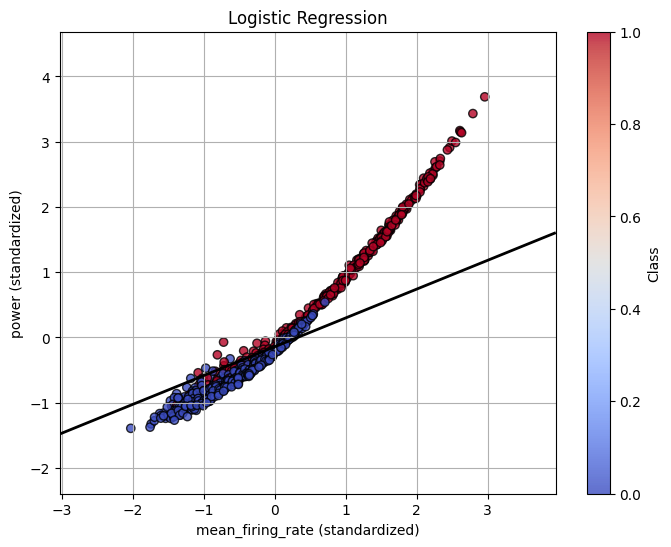


Accuracy: 0.79

Bias (w0): 0.6793

Feature                      Weight
________________________________________
mean_firing_rate            -2.0692
power                        4.6843

Confusion Matrix:
[[77 12]
 [22 49]]


In [252]:

##################### Plot Logistic Regression ###########################

#create grid
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
#predict probabilities
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

#plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap="coolwarm", edgecolors='k', alpha=0.8)
plt.contour(xx, yy, probs, levels=[0.5], linewidths=2, colors='black')
plt.xlabel(selected_features[0] + " (standardized)")
plt.ylabel(selected_features[1] + " (standardized)")
plt.title("Logistic Regression")
plt.grid(True)
plt.colorbar(scatter, label="Class")
plt.show()

########################### Evaluation  ###########################################


#accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

#bias 
bias= model.intercept_[0]
print(f"\nBias (w0): {bias:.4f}")

#weights table
print(f"\n{'Feature':<25}{'Weight':>10}")
print("_" * 40)

for feature_name, weight in zip(selected_features, model.coef_[0]):
    print(f"{feature_name:<25}{weight:>10.4f}")

#confusion matrix
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

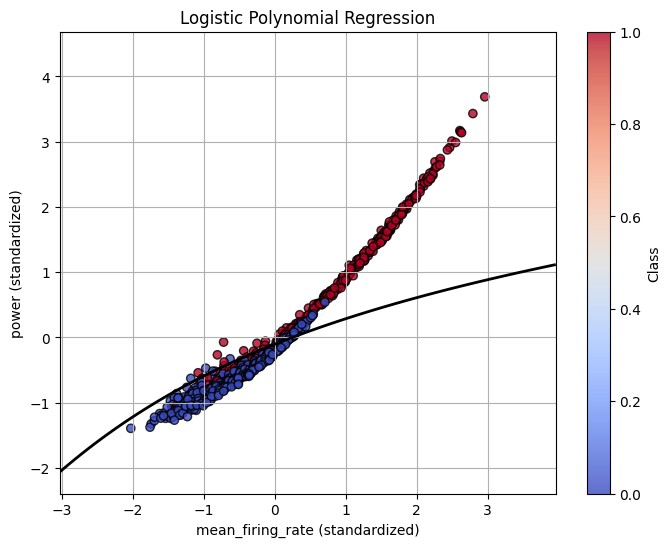


Accuracy: 0.8000

Bias (w0): 0.5266

Feature                           Weight
_____________________________________________
mean_firing_rate                 -2.0604
power                             4.8996
mean_firing_rate^2               -0.0955
mean_firing_rate power            0.9390
power^2                          -0.3849


Confusion Matrix:
[[80  9]
 [23 48]]


In [253]:
####################### Polynomial Logistic Regression ###########################


#create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

#train logistic regression on expanded features
model_poly = linear_model.LogisticRegression(max_iter=1000)
model_poly.fit(X_poly, y)

#create a grid
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
#flatten grid and transform it for polynomial features
grid = np.c_[xx.ravel(), yy.ravel()]
grid_poly = poly.transform(grid)

#predict on grid
probs = model_poly.predict_proba(grid_poly)[:, 1].reshape(xx.shape)

#predict test set
X_test_poly = poly.transform(X_test)
y_pred_poly = model_poly.predict(X_test_poly)


################################ Plot Polynomial Logistic Regression ###########################


plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap="coolwarm", edgecolors='k', alpha=0.8)
plt.contour(xx, yy, probs, levels=[0.5], linewidths=2, colors='black')

plt.xlabel(selected_features[0] + " (standardized)")
plt.ylabel(selected_features[1] + " (standardized)")
plt.title("Logistic Polynomial Regression")
plt.grid(True)
plt.colorbar(scatter, label="Class")
plt.show()

########################### Evaluation ###########################################

#accuracy
accuracy_poly = metrics.accuracy_score(y_test, y_pred_poly)
print(f"\nAccuracy: {accuracy_poly:.4f}")

#bias
print(f"\nBias (w0): {model_poly.intercept_[0]:.4f}")

#weights table
print(f"\n{'Feature':<30}{'Weight':>10}")
print("_" * 45)
feature_names_poly = poly.get_feature_names_out(selected_features)
for feature_name, weight in zip(feature_names_poly, model_poly.coef_[0]):
    print(f"{feature_name:<30}{weight:>10.4f}")

#confusion matrix
print("\n\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_poly))



### <span style="color:blue;">Observations</span>

- Classic Linear Logistic Regression and Logistic Regression with polynomial features differ only slightly in accuracy (ca.1 %)

- Two features do not suffice to make an acceptable model (only 80% Accuracy)

I will now use logistic regression with all the features and see how much it will improve.

In [257]:
###################### Logistic Regression on all features ############################


#selected_features = ['mean_firing_rate', 'power'] 
selected_features = features.columns.tolist()

X_features = features[selected_features].values
y = y

#standardize
X_mean = X_features.mean(axis=0)
X_std = X_features.std(axis=0)
X_scaled = (X_features - X_mean) / X_std

#split into training and test set (60/40 train/test)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.4, random_state=42)

#train
model = linear_model.LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#predict test set
y_pred = model.predict(X_test)


########################### Evaluation  ###########################################


#accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

#bias 
bias= model.intercept_[0]
print(f"\nBias (w0): {bias:.4f}")

#weights table
print(f"\n{'Feature':<25}{'Weight':>10}")
print("_" * 40)

for feature_name, weight in zip(selected_features, model.coef_[0]):
    print(f"{feature_name:<25}{weight:>10.4f}")

#confusion matrix
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred),'\n')


#print(metrics.classification_report(y_test, y_pred))


Accuracy: 0.84

Bias (w0): 0.4990

Feature                      Weight
________________________________________
mean_firing_rate             0.0604
synchrony_variance           1.7770
power                        2.1296
peak_frequency              -0.0174
fano_factor                 -0.7501

Confusion Matrix:
[[152  16]
 [ 34 118]] 



In [ ]:
########### Polynomial Logistic Regression with all  features ########################

#generate polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_features)

#train
model = linear_model.LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#################################### Evaluation ###################################

accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

bias = model.intercept_[0]
print(f"\nBias (w0): {bias:.4f}")

#weights table
feature_names = poly.get_feature_names_out(selected_features)

#limit features to 5
feature_names = feature_names[:5]

print(f"\n{'Feature':<35}{'Weight':>10}")
print("_" * 50)
for feature_name, weight in zip(feature_names, model.coef_[0]):
    print(f"{feature_name:<35}{weight:>10.4f}")
print("....\nTable shortened for readability")

#confusion Matrix
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred), '\n')

#print(metrics.classification_report(y_test, y_pred))


Accuracy: 0.8438

Bias (w0): 0.4990

Feature                                Weight
__________________________________________________
mean_firing_rate                       0.0604
synchrony_variance                     1.7770
power                                  2.1296
peak_frequency                        -0.0174
fano_factor                           -0.7501
....
Table shortened for readability

Confusion Matrix:
[[152  16]
 [ 34 118]] 



### <span style="color:blue;">Observations</span>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

#standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
######################## K-Nearest Neighbors ##################################

from sklearn.neighbors import KNeighborsClassifier

#train k-NN classifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

#predict and evaluate
y_pred_knn = knn.predict(X_test)

print(f"\nk-NN Accuracy: {metrics.accuracy_score(y_test, y_pred_knn):.2f}")
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_knn))
print(metrics.classification_report(y_test, y_pred_knn))


k-NN Accuracy: 0.83
Confusion Matrix:
[[156  12]
 [ 43 109]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       168
           1       0.90      0.72      0.80       152

    accuracy                           0.83       320
   macro avg       0.84      0.82      0.82       320
weighted avg       0.84      0.83      0.83       320



In [261]:
############################# LDA ###############################

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#train
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

#predict
y_pred_lda = lda.predict(X_test)

#evaluate
print(f"\nLDA Accuracy: {metrics.accuracy_score(y_test, y_pred_lda):.2f}")
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_lda))
print(metrics.classification_report(y_test, y_pred_lda))


LDA Accuracy: 0.86

Confusion Matrix:
[[159   9]
 [ 37 115]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       168
           1       0.93      0.76      0.83       152

    accuracy                           0.86       320
   macro avg       0.87      0.85      0.85       320
weighted avg       0.87      0.86      0.85       320



In [259]:
############################## Random Forest ###############################

from sklearn.ensemble import RandomForestClassifier

#train
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

#predict
y_pred_rf = forest.predict(X_test)

#evaluate
print(f"\nRandom Forest Accuracy: {metrics.accuracy_score(y_test, y_pred_rf):.2f}")
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(metrics.classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.84
Confusion Matrix:
[[147  21]
 [ 31 121]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       168
           1       0.85      0.80      0.82       152

    accuracy                           0.84       320
   macro avg       0.84      0.84      0.84       320
weighted avg       0.84      0.84      0.84       320



In [ ]:
######################## Regularized Least Squares #########################

from sklearn.linear_model import Ridge


#train
ridge = Ridge(alpha=1.0) #regularization strength alpha
ridge.fit(X_train, y_train)

#predict threshold
y_pred_scores = ridge.predict(X_test)
y_pred_ridge = (y_pred_scores >= 0.5).astype(int)

#evaluate
print(f"\nRegularized Least Squares Accuracy: {metrics.accuracy_score(y_test, y_pred_ridge):.2f}")
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_ridge))
print("\nClassification Report:")
print(metrics.classification_report(y_test, y_pred_ridge))



Regularized Least Squares Accuracy: 0.85
Confusion Matrix:
[[158  10]
 [ 39 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       168
           1       0.92      0.74      0.82       152

    accuracy                           0.85       320
   macro avg       0.86      0.84      0.84       320
weighted avg       0.86      0.85      0.84       320

